In [233]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil #move file from one folder to another
import glob

In [234]:
#count the numver of images in resptctive classes

ROOT_DIR = "brain_mri_scan_images"
no_of_images = {}

for dir in os.listdir(ROOT_DIR):
    dir_path = os.path.join(ROOT_DIR, dir)
    if os.path.isdir(dir_path):
        no_of_images[dir] = len(os.listdir(dir_path))

In [235]:
no_of_images.items()

dict_items([('positive', 1), ('negative', 3)])

split data as  
70% train\
15% validation\
15% testing

In [236]:
def datafolder(p, split):
    if not os.path.exists("./"+p):
        os.mkdir("./"+p)

        for dir in os.listdir(ROOT_DIR):
            os.makedirs("./"+p+"/"+dir)
            for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)),size = (math.floor(split*no_of_images[dir])-2), replace=False):
                O = os.path.join(ROOT_DIR, dir, img)
                D = os.path.join("./"+p, dir)
                shutil.copy(O,D)
                os.remove(O)
    else:
        print(f"the {p} folder exists!")

In [237]:
datafolder("train", 0.8)

the train folder exists!


In [238]:
datafolder("val", 0.15)

the val folder exists!


In [239]:
datafolder("test", 0.1)

the test folder exists!


<h3>Model building

In [240]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPool2D
from keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator
import keras

In [241]:
#CNN model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation= 'relu', input_shape = (224,224,3)))

model.add(Conv2D(filters = 36, kernel_size = (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units = 1, activation='sigmoid'))

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 220, 220, 36)   │         5,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 110, 110, 36)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 108, 108, 64)   │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,638,245 (21.51 MB)

 Trainable params: 5,638,245 (21.51 MB)

 Non-trainable params: 0 (0.00 B)

In [242]:
model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

<h4>Preparing data using data generator


In [243]:
def preprocessingImages1(path):
    image_data = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rescale=1/255, horizontal_flip=True) #increasing dimention
    image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')

    return image

In [244]:
path = 'train'
train_data = preprocessingImages1(path)

Found 177 images belonging to 2 classes.


In [245]:
def preprocessingImages2(path):
    image_data = ImageDataGenerator(rescale=1/255) #increasing dimention
    image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')

    return image

In [246]:
path='test'
test_data = preprocessingImages2(path)

Found 17 images belonging to 2 classes.


In [247]:
path='val'
val_data = preprocessingImages2(path)

Found 29 images belonging to 2 classes.


In [248]:
# early stopping and model check point

from keras.callbacks import ModelCheckpoint, EarlyStopping

#early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=6, verbose=1, mode='auto')


# model check point
# mc = ModelCheckpoint(monitor='val_accuracy', filepath='./bestmodel.h5', verbose = 1, save_best_only = True,  mode='auto')
mc = ModelCheckpoint(
    filepath='./bestmodel.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

cd = [es,mc]

<h4>Model Training


In [249]:
hs = model.fit(train_data, 
               steps_per_epoch = 8,
                epochs = 30,
                verbose = 1,
                validation_data = val_data,
                validation_steps = 16,
                callbacks = cd
                )

Epoch 1/30
6/8 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step - accuracy: 0.5266 - loss: 0.6966

2024-06-20 13:52:55.805793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 1: val_accuracy improved from -inf to 0.82759, saving model to ./bestmodel.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 602ms/step - accuracy: 0.5405 - loss: 0.6966 - val_accuracy: 0.8276 - val_loss: 0.6241
Epoch 2/30


2024-06-20 13:52:56.185636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/8 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step - accuracy: 0.6721 - loss: 0.6531

2024-06-20 13:53:02.024871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_accuracy did not improve from 0.82759
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 595ms/step - accuracy: 0.6651 - loss: 0.6563 - val_accuracy: 0.6552 - val_loss: 0.5987
Epoch 3/30


2024-06-20 13:53:02.287421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/8 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step - accuracy: 0.5803 - loss: 0.6782

2024-06-20 13:53:07.983287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 3: val_accuracy did not improve from 0.82759
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 597ms/step - accuracy: 0.5934 - loss: 0.6724 - val_accuracy: 0.8276 - val_loss: 0.5786
Epoch 4/30


2024-06-20 13:53:08.257531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/8 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step - accuracy: 0.7168 - loss: 0.6004

2024-06-20 13:53:14.482808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_accuracy did not improve from 0.82759
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 725ms/step - accuracy: 0.7128 - loss: 0.5951 - val_accuracy: 0.7931 - val_loss: 0.4474
Epoch 5/30


2024-06-20 13:53:14.758753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/8 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step - accuracy: 0.7404 - loss: 0.5667

2024-06-20 13:53:20.806555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 5: val_accuracy improved from 0.82759 to 0.86207, saving model to ./bestmodel.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 634ms/step - accuracy: 0.7403 - loss: 0.5682 - val_accuracy: 0.8621 - val_loss: 0.4673
Epoch 6/30


2024-06-20 13:53:21.078633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/8 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step - accuracy: 0.7096 - loss: 0.5273

2024-06-20 13:53:27.407534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 6: val_accuracy did not improve from 0.86207
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 658ms/step - accuracy: 0.7088 - loss: 0.5297 - val_accuracy: 0.8621 - val_loss: 0.4822
Epoch 7/30


2024-06-20 13:53:27.717420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/8 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step - accuracy: 0.7597 - loss: 0.5234

2024-06-20 13:53:33.833219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 7: val_accuracy did not improve from 0.86207
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 632ms/step - accuracy: 0.7703 - loss: 0.5133 - val_accuracy: 0.7931 - val_loss: 0.5466
Epoch 8/30


2024-06-20 13:53:34.108514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/8 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step - accuracy: 0.7663 - loss: 0.4691

2024-06-20 13:53:40.202044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_accuracy did not improve from 0.86207
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 634ms/step - accuracy: 0.7711 - loss: 0.4680 - val_accuracy: 0.7931 - val_loss: 0.6298
Epoch 9/30


2024-06-20 13:53:40.469483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/8 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step - accuracy: 0.8275 - loss: 0.4791

2024-06-20 13:53:46.567052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 9: val_accuracy did not improve from 0.86207
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 699ms/step - accuracy: 0.8212 - loss: 0.4776 - val_accuracy: 0.7931 - val_loss: 0.6192
Epoch 10/30


2024-06-20 13:53:46.837667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/8 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step - accuracy: 0.8863 - loss: 0.3668

2024-06-20 13:53:53.029690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 10: val_accuracy did not improve from 0.86207
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 646ms/step - accuracy: 0.8822 - loss: 0.3624 - val_accuracy: 0.7931 - val_loss: 0.7467
Epoch 11/30


2024-06-20 13:53:53.334726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/8 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step - accuracy: 0.7979 - loss: 0.4651

2024-06-20 13:53:59.550601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 11: val_accuracy did not improve from 0.86207
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 642ms/step - accuracy: 0.7976 - loss: 0.4733 - val_accuracy: 0.7931 - val_loss: 0.6164
Epoch 11: early stopping


2024-06-20 13:53:59.818335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [250]:
#plotting errors

h = hs.history
h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

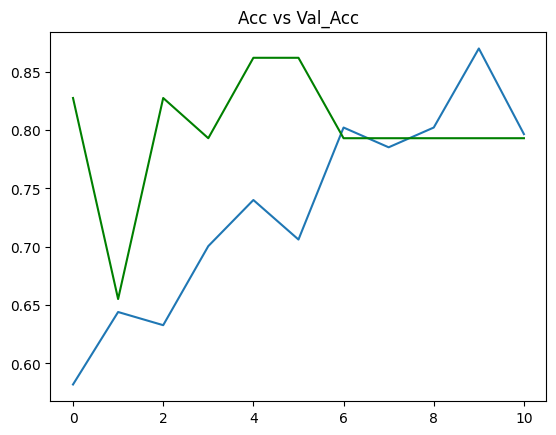

In [251]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = 'green')

plt.title("Acc vs Val_Acc")
plt.show()

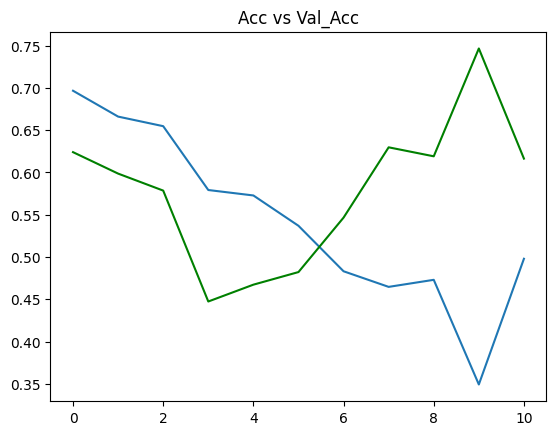

In [252]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = 'green')

plt.title("Acc vs Val_Acc")
plt.show()

In [253]:
# Model accuracy

from keras.models import load_model

model = load_model('bestmodel.keras')


In [254]:
acc = model.evaluate(test_data)[1]

print(f"the accuracy of the model is {acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.8824 - loss: 0.4026
the accuracy of the model is 0.8823529481887817


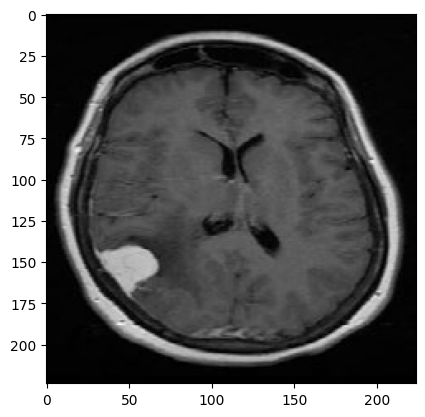

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
There is no tumor


In [265]:
from keras.preprocessing.image import load_img, img_to_array

path = "brain_mri_scan_images 2/positive/122.jpg"

img = load_img(path, target_size = (224, 224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr.shape

input_arr = np.expand_dims(input_arr, axis=0)

pred = model.predict(input_arr)[0][0]
pred

if pred == 0:
    print("The image shows that there is tumor")
else:
    print("There is no tumor")

In [262]:
train_data.class_indices

{'negative': 0, 'positive': 1}